In [1]:
import sys
sys.path.append("../")

import jax
import jax.numpy as np
from transformers import FlaxCLIPModel, AutoProcessor, AutoTokenizer

%matplotlib inline
%load_ext autoreload
%autoreload 2

2024-03-09 16:56:10.043841: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 16:56:10.044581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 16:56:10.135589: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from matplotlib import cm
cmap = matplotlib.colormaps.get_cmap('viridis_r')

# Ignore warning
import warnings
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

# Get plot params

from plot_params import params
pylab.rcParams.update(params)

# Set default colors to load at will
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
import yaml
from ml_collections.config_dict import ConfigDict

logging_dir = '/n/holystore01/LABS/iaifi_lab/Users/smsharma/multimodal-data/logging/proposals/'
run_name = 'glistening-kumquat-123'

config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [5]:
import optax 
from flax.training import checkpoints, common_utils, train_state

import flax

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1e-4,
    warmup_steps=5_000,
    decay_steps=100_000,
)

tx = optax.adamw(learning_rate=schedule, weight_decay=1e-4)
state = train_state.TrainState.create(apply_fn=model.__call__, params=model.params, tx=tx)

In [36]:
model_large = FlaxCLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor_large = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
tokenizer_large = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")

state_large = train_state.TrainState.create(apply_fn=model_large.__call__, params=model_large.params, tx=tx)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [7]:
import orbax.checkpoint as ocp

In [8]:
def cosine_similarity(vec1, vec2):
    
    norm_vec1 = np.linalg.norm(vec1, axis=-1,)
    norm_vec2 = np.linalg.norm(vec2, axis=-1,)
        
    return np.dot(vec1, vec2) / (norm_vec1 * norm_vec2)

## Regular

In [9]:
from utils.text_utils import process_truncate_captions

In [10]:
from tqdm import tqdm
import tensorflow as tf
from utils.dataset_utils import make_dataloader, create_input_iter
from dm_pix import center_crop, random_crop, rotate, random_flip_up_down, random_flip_left_right

In [11]:
import pandas as pd

# Loading the dataframes
sum1_filename = "../data/summary_sum1_v3.csv"
sum1_df = pd.read_csv(sum1_filename)

summaries_filename = "../data/summary_v2.csv"
summaries_df = pd.read_csv(summaries_filename)

# Merging the dataframes
sum_merged = pd.merge(summaries_df, sum1_df, on='proposal_id')

# Function to process each caption
def get_objects_phenomena(caption):
    first_part = caption.split(';')[0]
    match = sum_merged[sum_merged['objects_phenomena_x'] == first_part]['objects_phenomena_y']
    return match.values[0] if not (match.empty or pd.isna(match.values[0])) else "None"

In [29]:
from functools import partial
from einops import rearrange
import numpy as onp

    
def get_features_ds(state, model, processor, ds, truncate=False, use_sum1=False, randomize_objects=False, num_rnd=3):

    @partial(jax.pmap, axis_name="batch")
    def get_features(state, input_ids, pixel_values, attention_mask):
        captions_feat = model.get_text_features(input_ids, attention_mask, params=state.params)
        images_feat = model.get_image_features(pixel_values, params=state.params)
        return images_feat, captions_feat

    batches = iter(ds)

    image_feat_stack = []
    images_stack = []
    captions_stack = []
    captions_feat_stack = []
    
    num_local_devices = jax.local_device_count()
    replicate = flax.jax_utils.replicate
    
    total_batches = sum(1 for _ in ds) - 1
    current_batch = 0

    for (images, captions) in tqdm(batches, total=total_batches):
        if current_batch == total_batches - 1:
            break
    
        images = np.array(images)

        if truncate:
            rng_seed = onp.random.randint(99999)
            captions = process_truncate_captions(captions, jax.random.PRNGKey(rng_seed), max_length_words=config.data.max_length_words)
        else:
            captions = captions.numpy().tolist()
            captions = [c.decode('utf-8') for c in captions]

        if randomize_objects:
            captions_rnd = []
            for caption in captions:
                list_rnd = onp.random.choice(", ".join(caption.split(';')).split(', '), num_rnd)
                # Join into comma separated string
                list_rnd = ", ".join(list_rnd)
                captions_rnd.append(list_rnd)
    
            captions = captions_rnd
        
        if use_sum1:
            captions_sum1 = []
            for caption in captions:
                sum1 = sum_merged[sum_merged['objects_phenomena_x'] == caption.split(';')[0]]['objects_phenomena_y'].values[0]
                if sum1 is np.nan:
                    sum1 = "None"
                captions_sum1 += [sum1]
                
            captions_stack += captions_sum1
        else:
            captions_stack += captions

        images_stack.append(images)

        rng_eval = jax.random.PRNGKey(onp.random.randint(99999))
        
        # Rotation angles in rad
        rot_angles_90 = np.array([0.0, np.pi / 2, np.pi, 3 * np.pi / 2])

        # Rotations
        rng_eval, _ = jax.random.split(rng_eval)
        # rotation_angles = jax.random.uniform(rng_eval, shape=(images.shape[0],)) * 2 * np.pi  # Angles in radians
        rotation_angles = jax.random.choice(
            rng_eval, rot_angles_90, shape=(images.shape[0],)
        )  # Angles in radians

        images = jax.vmap(partial(rotate, mode='constant', cval=1.))(images, rotation_angles)
        
        # Flips
        rng_eval, _ = jax.random.split(rng_eval)
        images = jax.vmap(partial(random_flip_up_down, key=rng_eval))(image=images)

        rng_eval, _ = jax.random.split(rng_eval)
        images = jax.vmap(partial(random_flip_left_right, key=rng_eval))(image=images)

        images = jax.vmap(random_crop, in_axes=(None,0,None))(rng_eval, images, (model.config.vision_config.image_size, model.config.vision_config.image_size, 3))

        input = processor(text=captions_sum1 if use_sum1 else captions, images=(images * 255.).astype(np.uint8), return_tensors="np", padding="max_length", truncation=True, max_length=77)
    
        batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), input.data)
    
        image_feat, captions_feat = get_features(replicate(state), np.array(batch["input_ids"]), np.array(batch["pixel_values"]), np.array(batch["attention_mask"]))

        image_feat = rearrange(image_feat, "d b e -> (d b) e")
        captions_feat = rearrange(captions_feat, "d b e -> (d b) e")

        captions_feat_stack.append(captions_feat)
        image_feat_stack.append(image_feat)

        current_batch += 1

    return image_feat_stack, captions_feat_stack, images_stack, captions_stack

## Multiple runs

In [30]:
def get_roc(image_feat, captions_feat):
    
    roc_mat = np.matmul(image_feat, captions_feat.T)
    
    correct_indices = np.arange(roc_mat.shape[0])[:, None]
    top_indices = np.argsort(roc_mat, axis=-1)
    
    accuracy_list = []
    for k in np.arange(1, roc_mat.shape[0], 100):
        correct_in_top_k = np.any(top_indices[:, -k:] == correct_indices, axis=-1)
        accuracy = np.mean(correct_in_top_k.astype(np.float32))
        accuracy_list.append(accuracy)

    return accuracy_list

In [31]:
def retrieval_eval_metric(text_embeds, image_embeds, k=[1, 5, 10, 20]):
    """ Compute the top-k retrieval accuracy.
    """

    # Get shapes
    bs = text_embeds.shape[0]
    axis_size = jax.lax.psum(1, axis_name="batch")

    # Gather the embeddings from all devices
    all_text_embeds = jax.lax.all_gather(text_embeds, axis_name="batch").reshape(-1, text_embeds.shape[-1])
    all_image_embeds = jax.lax.all_gather(image_embeds, axis_name="batch").reshape(-1, image_embeds.shape[-1])

    # Compute the full matrix of logitseval
    all_logits = np.matmul(all_text_embeds, all_image_embeds.T)

    # Compute the global top-k indices for the maximum k value
    max_k = max(k)
    top_k_indices = np.argsort(all_logits, axis=-1)[:, -max_k:]

    # Compute the correct indices for each row
    correct_indices = np.arange(bs * axis_size)[:, None]

    metrics = {}
    for current_k in k:
        # Check if the correct image (diagonal) is in the current top-k for each text embedding
        correct_in_top_k = np.any(top_k_indices[:, -current_k:] == correct_indices, axis=-1)
        accuracy = np.mean(correct_in_top_k.astype(np.float32))
        metrics[f"top_{current_k}_accuracy"] = accuracy

    return metrics

In [37]:
run_labels = ['major-meadow-131',
              'exalted-cosmos-130',
              'magic-oath-132',
              'glistening-kumquat-123',
              "base"
              ]

run_legends = [r'Fine-tune (summaries), \texttt{clip-vit-large-patch14}', 
               r'Fine-tune (summaries), $\mathrm{LR}=10^{-6}$', 
               r'Fine-tune (summaries), cosine LR schedule', 
               'Fine-tune (summaries)', 
               'base'
               ]


data_type = ["summary", "summary", "summary","summary","summary",]
use_sum1 = [False, False, False, False,False,]

cols_list = [cols_default[0], cols_default[1], cols_default[5], cols_default[3], cols_default[4]]
ls_list = ['-', '-', '-', '-', '-']

model_is_large = [True, False, False, False, False]

In [33]:
accuracy_lists = []

In [38]:
for idx, run_name in enumerate(tqdm(run_labels[:])):

    files = tf.io.gfile.glob(f"/n/holyscratch01/iaifi_lab/smsharma/hubble_data/tfrecords_v5/*val*.tfrecord")
    ds = make_dataloader(files, batch_size=100, seed=324, split="val", shuffle=True, caption_type=data_type[idx])
    
    if run_name == "base":
        restored_state = state  
    else:
        ckpt_dir = "{}/{}".format(logging_dir, run_name)  # Load SLURM run
        
        best_fn = lambda metrics: metrics[f"val/loss"]
        
        mgr_options = ocp.CheckpointManagerOptions(step_prefix=f'step', best_fn=best_fn, best_mode='min', create=False)

        ckpt_mgr_load_ckpt = ocp.CheckpointManager(
            f"{ckpt_dir}/ckpts/",
            options=mgr_options,
        )

        if model_is_large[idx]:
            restored_state = ckpt_mgr_load_ckpt.restore(
                ckpt_mgr_load_ckpt.latest_step(),
                args=ocp.args.StandardRestore(state_large)
            )

            if state_large is restored_state:
                raise FileNotFoundError(f"Did not load checkpoint correctly")

        else:
            restored_state = ckpt_mgr_load_ckpt.restore(
                ckpt_mgr_load_ckpt.latest_step(),
                args=ocp.args.StandardRestore(state)
            )
        
            if state is restored_state:
                raise FileNotFoundError(f"Did not load checkpoint correctly")

    image_feat_stack, captions_feat_stack, _, _ = get_features_ds(restored_state, 
                                                                  model_large if model_is_large[idx] else model, 
                                                                  processor_large if model_is_large[idx] else processor, 
                                                                  ds, truncate=data_type[idx] == "abstract", use_sum1=use_sum1[idx], randomize_objects=False, num_rnd=3)
    
    accuracy_list = get_roc(np.vstack(image_feat_stack), np.vstack(captions_feat_stack))
    accuracy_lists.append(accuracy_list)

100%|██████████| 5/5 [07:51<00:00, 94.31s/it]


In [86]:
run_labels = ['major-meadow-131',
              'exalted-cosmos-130',
              'magic-oath-132',
              'glistening-kumquat-123',
              "base"
              ]

run_legends = [r'Fine-tune larger CLIP model', 
               r'$\mathrm{LR}=10^{-6}$', 
               r'Cosine LR schedule', 
               'Fine-tune (summaries)', 
               'Base'
               ]


data_type = ["summary", "summary", "summary","summary","summary",]
use_sum1 = [False, False, False, False,False,]

cols_list = [cols_default[0], cols_default[2],cols_default[2],  cols_default[0], cols_default[3], ]
ls_list = [':', '--', '-', '-', '-']

model_is_large = [True, False, False, False, False]
alpha_list = [1.0, 1.0, 0.5, 1.0, 1.0]

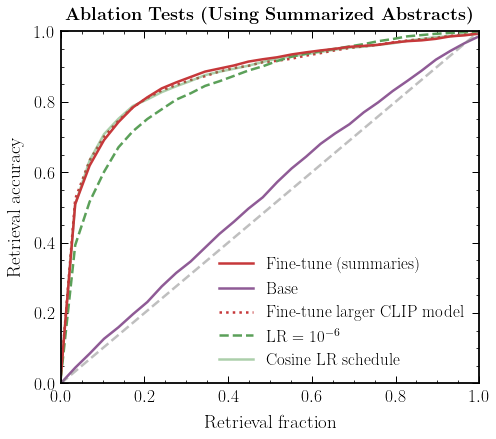

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6.2))

for idx, accuracy_list in enumerate(accuracy_lists):
    ax.plot(np.linspace(0., 1., len(accuracy_list)), accuracy_list, label=run_legends[idx], color=cols_list[idx], ls=ls_list[idx], alpha=alpha_list[idx])

ax.plot([0, 1], [0, 1], ls='--', alpha=0.5, color='grey')
    
ax.legend()

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel("Retrieval fraction")
ax.set_ylabel("Retrieval accuracy")

# ax.legend(frameon=False, framealpha=0.9)

# In the legend, show the last two runs first (first the second last, then the last, then the rest)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:] + handles[:-2], labels[-2:] + labels[:-2], frameon=False,)

ax.set_title(r"\textbf{Ablation Tests (Using Summarized Abstracts)}", y=1.01)

plt.tight_layout()

plt.savefig("../paper/plots/retrieval_app.pdf")
